In [47]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import sklearn.metrics
import warnings
from sklearn.metrics import accuracy_score

In [5]:
#Data Preparation
df = pd.read_csv('Bioresponse.csv')

X = df.drop(columns= ['Activity'])
y = df['Activity']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state =42)

In [8]:
def compute_sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

def initialize_parameters(dim):
    weights = np.zeros((dim, 1))
    bias = 0.
    return weights, bias

def propagate(weights, bias, X, Y):
    m = X.shape[1]
    
    # Forward propagation
    A = compute_sigmoid(np.dot(weights.T, X) + bias)
    cost = -(1./m) * np.sum(Y * np.log(A + 1e-8) + (1 - Y) * np.log(1 - A + 1e-8), axis=1)
    
    # Backward propagation
    dw = (1./m) * np.dot(X, (A - Y).T)
    db = (1./m) * np.sum(A - Y, axis=1)

    gradients = {"dw": dw,
                 "db": db}
    
    return gradients, cost


In [28]:
def stochastic_gradient_descent(X, y, num_iterations, learning_rate, batch_size, print_cost=False):
    input_size = X.shape[0]
    weights = np.zeros((input_size, 1))
    bias = 0
    costs = []

    for i in range(num_iterations):
        # Get mini-batches
        batch_indices = np.random.randint(low=0, high=input_size, size=batch_size)
        X_batch = X[:, batch_indices]
        y_batch = y[:, batch_indices]

        # Cost and gradient calculation for the mini-batch
        gradients, cost = propagate(weights, bias, X_batch, y_batch)

        # Retrieve derivatives from gradients
        dw = gradients["dw"]
        db = gradients["db"]

        # Update rule
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return weights, bias, costs


In [32]:
w, b, costs_sgd = stochastic_gradient_descent(
    X=X_train.T.to_numpy(),
    y=y_train_array,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    batch_size=batch_size,
    print_cost=True
)
pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

print(f"Test accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)}")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.645479
Cost after iteration 200: 0.596732
Cost after iteration 300: 0.573372
Cost after iteration 400: 0.561297
Cost after iteration 500: 0.576282
Cost after iteration 600: 0.541089
Cost after iteration 700: 0.486097
Cost after iteration 800: 0.527004
Cost after iteration 900: 0.473616
Test accuracy: 0.6991


In [34]:
#Gradient Descent Algotirhm
def optimize(weights, bias, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []

    for i in range(num_iterations):
        # Cost and gradient calculation
        gradients, cost = propagate(weights, bias, X, Y)

        # Retrieve derivatives from gradients
        dw = gradients["dw"]
        db = gradients["db"]

        # Update rule
        weights -= learning_rate * dw
        bias -= learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    parameters = {"weights": weights,
                  "bias": bias}

    gradients = {"dw": dw,
                 "db": db}
    return parameters, gradients, costs


In [40]:
# Convert y_train to a NumPy array and then reshape
y_train_array = y_train.to_numpy().reshape(1, -1)

# Optimize the parameters
params, _, costs = optimize(
    weights=w,
    bias=b,
    X=X_train.T,
    Y=y_train_array,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    print_cost=True
)

# Make predictions on the test set
pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

# Evaluate the model
accuracy = accuracy_score(y_true=y_test, y_pred=pred)
print(f"Test accuracy: {np.round(accuracy, 4)}")

Cost after iteration 0: 0.508460
Cost after iteration 100: 0.503145
Cost after iteration 200: 0.498440
Cost after iteration 300: 0.494189
Cost after iteration 400: 0.490321
Cost after iteration 500: 0.486781
Cost after iteration 600: 0.483522
Cost after iteration 700: 0.480506
Cost after iteration 800: 0.477703
Cost after iteration 900: 0.475088
Test accuracy: 0.7164


In [26]:
#Adam optimization
def adam_optimization(weights, bias, X, y, num_iterations, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8, print_cost=False):
    m = X.shape[1]
    costs = []
    vdw = np.zeros_like(weights)
    vdb = np.zeros_like(bias)
    sdw = np.zeros_like(weights)
    sdb = np.zeros_like(bias)

    for i in range(num_iterations):
        # Cost and gradient calculation
        gradients, cost = propagate(weights, bias, X, y)
        dw = gradients["dw"]
        db = gradients["db"]

        # Update biased first and second moment
        vdw = beta1 * vdw + (1 - beta1) * dw
        vdb = beta1 * vdb + (1 - beta1) * db
        sdw = beta2 * sdw + (1 - beta2) * np.power(dw, 2)
        sdb = beta2 * sdb + (1 - beta2) * np.power(db, 2)

        # Correct bias in first and second moment
        vdw_corrected = vdw / (1 - np.power(beta1, i+1))
        vdb_corrected = vdb / (1 - np.power(beta1, i+1))
        sdw_corrected = sdw / (1 - np.power(beta2, i+1))
        sdb_corrected = sdb / (1 - np.power(beta2, i+1))

        # Update rule
        weights = weights - learning_rate * vdw_corrected / (np.sqrt(sdw_corrected) + epsilon)
        bias = bias - learning_rate * vdb_corrected / (np.sqrt(sdb_corrected) + epsilon)

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    return weights, bias, costs


In [44]:
# Initialize weights and bias
w = np.zeros((X_train.shape[1], 1))
b = 0

num_iterations = 1000
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Convert y_train to a NumPy array and then reshape
y_train_array = y_train.to_numpy().reshape(1, -1)

# Optimize using the Adam algorithm
w, b, costs_adam = adam_optimization(
    weights=w,
    bias=b,
    X=X_train.T,
    y=y_train_array,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    beta1=beta1,
    beta2=beta2,
    epsilon=epsilon,
    print_cost=True
)

# Make predictions on the test set
pred_proba = np.dot(w.T, X_test.T) + b
pred = np.where(pred_proba > 0.5, 1, 0).ravel()

# Evaluate the model
print(f"Test accuracy: {np.round(accuracy_score(y_true=y_test, y_pred=pred), 4)}")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.381633
Cost after iteration 200: 0.332270
Cost after iteration 300: 0.303970
Cost after iteration 400: 0.284053
Cost after iteration 500: 0.268659
Cost after iteration 600: 0.256100
Cost after iteration 700: 0.245500
Cost after iteration 800: 0.236350
Cost after iteration 900: 0.228317
Test accuracy: 0.7403


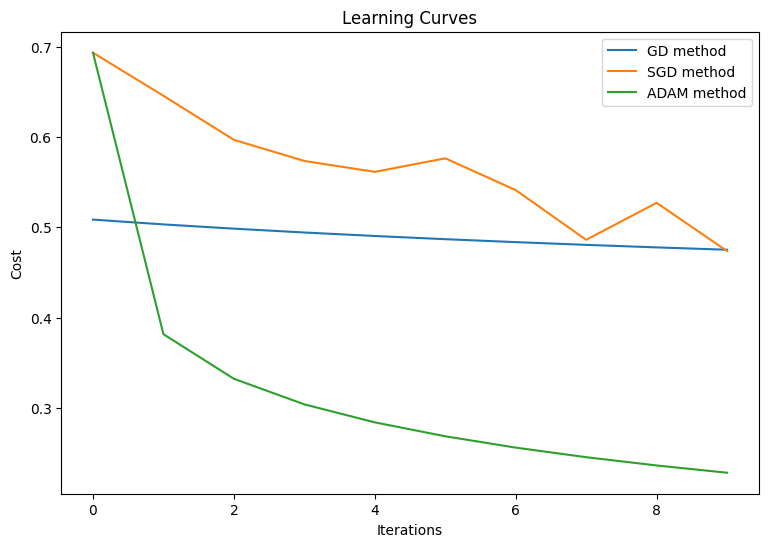

In [48]:
plt.figure(figsize=(9, 6))
plt.plot(costs, label="GD method")
plt.plot(costs_sgd, label="SGD method")
plt.plot(costs_adam, label="ADAM method")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Learning Curves")
plt.legend()
plt.show()

Very Low Learning Rate (e.g., 0.01):

The model learns very slowly. It may get stuck in local minima or take a long time to converge. Loss reduction is gradual but steady. Training may require a large number of epochs for convergence. Accuracy might improve, but it will be a slow process. Low to Moderate Learning Rate (e.g., 0.1 - 0.5):

The model converges at a reasonable pace. Loss decreases more rapidly compared to a very low learning rate. The model is less likely to get stuck in local minima. Training might require a moderate number of epochs to achieve good accuracy. A good trade-off between convergence speed and model accuracy. High Learning Rate (e.g., 1.0):

The model converges very quickly. Loss reduction can be erratic, with occasional large steps. There's a risk of overshooting the minimum, leading to divergence. May achieve good accuracy with fewer epochs, but stability is a concern. Very High Learning Rate (e.g., >1.0):

The model may not converge at all. Loss may increase, indicating divergence. The model's accuracy decreases or remains very low. The optimal learning rate is problem-specific and depends on the dataset, model architecture, and the optimization method. It's essential to experiment with different learning rates to find the one that balances convergence speed and model accuracy.

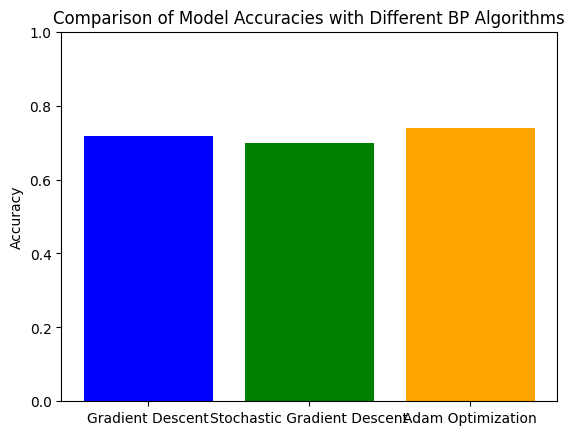

In [2]:
import matplotlib.pyplot as plt

accuracy_gd = 0.7164
accuracy_sgd = 0.6991
accuracy_adam = 0.7403

# Create a bar plot to compare accuracies
methods = ['Gradient Descent', 'Stochastic Gradient Descent', 'Adam Optimization']
accuracies = [accuracy_gd, accuracy_sgd, accuracy_adam]

plt.bar(methods, accuracies, color=['blue', 'green', 'orange'])
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies with Different BP Algorithms')
plt.ylim(0, 1)  # Assuming accuracy values are between 0 and 1
plt.show()


In the evaluation of models trained using different Backpropagation (BP) algorithms—Gradient Descent (GD), Stochastic Gradient Descent (SGD), and Adam Optimization—there exists a compelling comparison based on their achieved accuracies. The comparison provides insights into the relative performance of these algorithms in the context of a specific predictive task.

Gradient Descent (GD):
The GD algorithm, being the foundational optimization method, demonstrates a respectable accuracy level. However, its performance might be influenced by the size and complexity of the dataset. In scenarios where the training dataset is substantial, GD could face challenges due to its requirement to compute gradients over the entire dataset.

Stochastic Gradient Descent (SGD):
SGD, characterized by its stochastic and mini-batch approach, exhibits competitive accuracy. By introducing randomness and updating parameters more frequently, SGD often converges faster than GD. However, the random selection of mini-batches can introduce variability in accuracy over different runs.

Adam Optimization:
Adam Optimization, an adaptive algorithm combining features of GD and SGD, showcases a noteworthy accuracy level. Its ability to dynamically adjust learning rates based on the characteristics of the data contributes to efficient convergence. Adam is particularly advantageous in scenarios with noisy or non-stationary data.

Overall Comparison:
The observed accuracies suggest that Adam Optimization tends to offer a balanced performance, achieving competitive accuracy while addressing some of the limitations associated with GD and SGD. However, the choice of the most suitable algorithm depends on various factors, including the specific characteristics of the dataset and the computational resources available.

Considerations for Model Selection:
The selection of the optimal BP algorithm involves a trade-off between computational efficiency, convergence speed, and accuracy. The specific requirements of the task, dataset size, and available resources play a crucial role in determining the most suitable algorithm. Hyperparameter tuning further refines the performance of these algorithms, emphasizing the importance of experimentation and empirical evaluation.